In [1]:
import pandas as pd
import nltk
from nltk.util import ngrams
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
file_path = 'Reviews_F1.csv'
df = pd.read_csv(file_path)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\usha_\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usha_\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\usha_\AppData\Roaming\nltk_data...


In [3]:
# Combine all text into a single corpus
corpus = ' '.join(df['Text'].astype(str))

# Tokenize the corpus
tokens = nltk.word_tokenize(corpus.lower())

# Create n-grams (up to 5-grams)
n_grams = [list(ngrams(tokens, i)) for i in range(1, 6)]

# Build n-gram models
n_gram_models = [defaultdict(Counter) for _ in range(5)]

for i, grams in enumerate(n_grams):
    for gram in grams:
        if i == 0:
            n_gram_models[i][()][gram] += 1
        else:
            n_gram_models[i][gram[:-1]][gram[-1]] += 1

# Function to predict next word
def predict_next_word(words, n=3):
    predictions = []
    context = tuple(words[-4:])  # Use up to 4 words of context

    for i in range(min(len(context), 4), -1, -1):
        current_context = context[-i:]
        if current_context in n_gram_models[i]:
            candidates = n_gram_models[i][current_context].most_common(10)
            for word, _ in candidates:
                if word not in predictions:
                    predictions.append(word)
                    if len(predictions) == n:
                        return predictions

    return predictions[:n]

# Test sentence
test_sentence = "I love these cookies. I am on the paleo diet right now and these cookies"
test_tokens = nltk.word_tokenize(test_sentence.lower())

# Predict next words
predicted_words = predict_next_word(test_tokens)
print("Top 3 predicted words:", predicted_words)


Top 3 predicted words: ['are', '.', 'close']


In [5]:
# Function for comprehensive text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text.lower())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Remove non-alphabetic characters
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    tokens = [token for token in tokens if token]
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return stemmed_tokens, lemmatized_tokens

# Apply preprocessing to each text in the dataset
df['preprocessed_stemmed'], df['preprocessed_lemmatized'] = zip(*df['Text'].apply(preprocess_text))


In [7]:
# Train Word2Vec model using Skip-Gram
model_sg = Word2Vec(df['preprocessed_lemmatized'].tolist(), vector_size=100, window=5, min_count=5, workers=4, sg=1, negative=10)

# Count word frequencies in the corpus
word_freq = Counter([word for text in df['preprocessed_lemmatized'] for word in text])


In [9]:
# Function to get word vector
def get_word_vector(word):
    try:
        return model_sg.wv[word]
    except KeyError:
        print(f"Warning: '{word}' not in vocabulary")
        return None

# Custom similarity function
def custom_similarity(word1, word2):
    try:
        cos_sim = model_sg.wv.similarity(word1, word2)
    except KeyError:
        return 0.0
    freq_factor = np.log(word_freq[word2] + 1)  # Log to dampen the effect of very frequent words
    return cos_sim * freq_factor

In [11]:
# Function to find top N similar words with relevance filtering
def find_similar_words(word, n=2):
    word_vector = get_word_vector(word)
    if word_vector is None:
        return []

    # Define a set of relevant terms
    relevant_terms = {'cookie', 'bake', 'sweet', 'taste', 'flavor', 'chocolate', 'sugar', 'crunchy', 'soft', 'delicious', 'snack', 'dessert'}

    similarities = []
    for w in model_sg.wv.index_to_key:
        if w != word:
            sim = custom_similarity(word, w)
            if w in relevant_terms or w.endswith('y'):
                similarities.append((w, sim))

    return sorted(similarities, key=lambda x: x[1], reverse=True)[:n]

# Example: Get vector for a word
cookie_vector = get_word_vector('cookie')
if cookie_vector is not None:
    print("Vector for 'cookie':", cookie_vector[:5])  # Print first 5 elements
else:
    print("Could not get vector for 'cookie'")

# Example: Find similar words
similar_words = find_similar_words('cookie')
print("Words similar to 'cookie':", similar_words)


Vector for 'cookie': [-0.13483171  0.09790277  0.02028527  0.1255435  -0.14924306]
Words similar to 'cookie': [('flavor', 5.8596670282065535), ('taste', 5.314100040305532)]


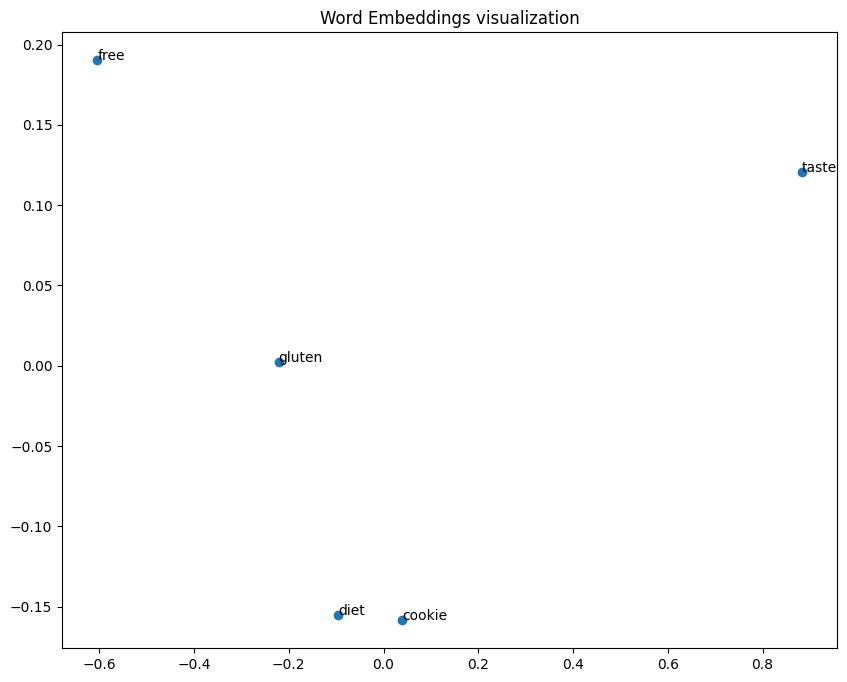

Vocabulary size: 1700
Some common words: ['br', 's', 'nt', 'like', 'flavor', 'good', 'taste', 'one', 'product', 'great']
Sample preprocessed text: ['love', 'cooky', 'paleo', 'diet', 'right', 'cooky', 'look', 'forward', 'like', 'taste', 'tropical', 'one', 'best', 'different', 'taste', 'want', 'something', 'grain', 'free', 'gluten', 'free', 'right', 'place', 'expected', 'taste', 'different', 'reviewer', 'seem', 'expect', 'taste', 'like', 'oreo', 'chip', 'ahoy', 'course', 'not', 'br', 'br', 'eat', 'nt', 'even', 'feel', 'bad', 'body', 'welcome', 'nt', 'make', 'crash', 'either', 'feel', 'like', 'ate', 'junk', 'food', 'good', 'indicator', 'made', 'natural', 'ingredient', 'wish', 'cooky', 'close', 'd', 'buy', 'every', 'single', 'day']


In [13]:
# Visualize a subset of vector embeddings
def visualize_embeddings(words):
    # Filter words that are in the vocabulary
    valid_words = [word for word in words if word in model_sg.wv]

    if not valid_words:
        print("None of the specified words are in the vocabulary.")
        return

    vectors = [model_sg.wv[word] for word in valid_words]

    pca = PCA(n_components=2)
    result = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(valid_words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.title('Word Embeddings visualization')
    plt.show()

# Example: Visualize embeddings for a subset of words
subset_words = ['cookie', 'paleo', 'diet', 'gluten', 'free', 'taste']
visualize_embeddings(subset_words)

# Print some diagnostic information
print("Vocabulary size:", len(model_sg.wv.key_to_index))
print("Some common words:", list(model_sg.wv.key_to_index.keys())[:10])
print("Sample preprocessed text:", df['preprocessed_lemmatized'].iloc[0])
